In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
import joblib
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Pre-processing

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [4]:
new_col = pd.read_csv('data/gender_submission.csv')
df_test['Survived'] = new_col['Survived']

In [5]:
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [6]:
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked']
df = df.drop(cols_to_drop, axis=1)

In [7]:
df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())

df = pd.get_dummies(df, 'sex')
df

,Survived,Pclass,Age,SibSp,Parch,Fare,sex_female,sex_male
0,0,3,22.000000,1,0,7.2500,False,True
1,1,1,38.000000,1,0,71.2833,True,False
2,1,3,26.000000,0,0,7.9250,True,False
3,1,1,35.000000,1,0,53.1000,True,False
4,0,3,35.000000,0,0,8.0500,False,True
...,...,...,...,...,...,...,...,...
1304,0,3,29.881138,0,0,8.0500,False,True
1305,1,1,39.000000,0,0,108.9000,True,False
1306,0,3,38.500000,0,0,7.2500,False,True
1307,0,3,29.881138,0,0,8.0500,False,True


In [8]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [9]:
# Data normalization

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
# Feature ranking

estimator = SVC(kernel='linear')
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X, y)

print('Feature ranking:')
columns = df.drop('Survived', axis=1).columns
ranking = selector.ranking_
for feature, rank in sorted(zip(columns, ranking), key=lambda x: x[1]):
    print(f'{feature}: {rank}')

Feature ranking:
sex_male: 1
sex_female: 2
Parch: 3
Pclass: 4
Age: 5
Fare: 6
SibSp: 7


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling

In [12]:
model = SVC()

In [13]:
# Model tuning

not_tuned = not os.path.exists('model.pkl')
wants_to_tune = False if not_tuned else input('Do you want to tune the model? (y/n) ').lower() == 'y'

if not_tuned or wants_to_tune:
    parameters = {
        'C': [0.1, 1, 10],
        'gamma': [1, 0.1, 0.01],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }

    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    grid = GridSearchCV(model, param_grid=parameters, cv=kf)
    grid = grid.fit(X_train, y_train)
    model = grid.best_estimator_

    print('score = %3.2f' %(grid.score(X_test, y_test)))
    print(grid.best_params_)

    joblib.dump(model, 'model.pkl')
else:
    model = joblib.load('model.pkl')

score = 0.87
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [14]:
y_pred = model.predict(X_test)

# Model evaluation

Accuracy: 86.64%
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       159
           1       0.85      0.81      0.83       103

    accuracy                           0.87       262
   macro avg       0.86      0.86      0.86       262
weighted avg       0.87      0.87      0.87       262



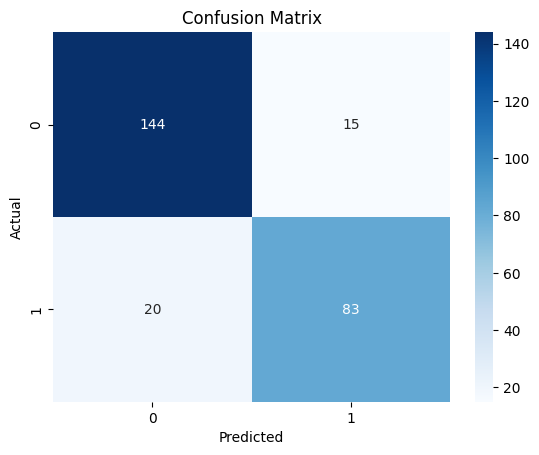

In [15]:
confusion = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)*100

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

print('Accuracy: %3.2f%%' %(acc))
print(classification_report(y_test, y_pred))